In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import json
import sys
import glob
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.collections import LineCollection
import seaborn as sns
import rasterio.plot
import rasterio.mask
from rasterio.crs import CRS

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# I think it also could make sense to pass in scenario and
# ddf type as arguments. For main results
# we're using 'mid' and 'naccs' but for generating
# our sensitivity analysis results we will need to pass
# in the other scenarios and 'hazus'
scenarios = ['Mid']
ddf_types = ['naccs']

# Load data

In [7]:
# Load geospatial data
clip_geo = gpd.read_file(join(REF_DIR_I, FIPS, "clip.gpkg"))
tract_geo = gpd.read_file(join(REF_DIR_I, FIPS, "tract.gpkg"))
bg_geo = gpd.read_file(join(REF_DIR_I, FIPS, "bg.gpkg"))
nsi_geo = gpd.read_file(join(EXP_DIR_I, FIPS, "nsi_sf.gpkg"))

# including vulnerability data
lmi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'lmi.gpkg'))
ovb = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'ovb.gpkg'))
cejst = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'cejst.gpkg'))
sovi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'sovi.gpkg'))
# and the indicators dataframe to subset for maps
c_ind = pd.read_parquet(join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt'))

In [8]:
# For the figures, we need the following data

# The objective evaluations for each policy
obj_filep = join(FO, 'pol_obj_vals.pqt')
objs = pd.read_parquet(obj_filep)

# The houses that are elevated for each policy
elev_ids_filep = join(FO, 'pol_elev_ids.json')
with open(elev_ids_filep, 'r') as fp:
    elev_ids = json.load(fp)

# The ensemble w/ opt heightenings & associated values
# We will do some plots based on the expected value of some
# metrics across SOWs
# Load the ensemble data, along with the optimal
# elevation results
ens_agg_dfs = {}

for scen in scenarios:
    ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
    ens_df = pd.read_parquet(ens_filep)
    print('Load data: ' + scen)
    
    for ddf_type in ddf_types:
        opt_elev_filename = 'ens_opt_elev_' + ddf_type + '_' + scen + '.pqt'
        opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
        print('Load opt elev: ' + ddf_type)

        # Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
        # into the ensemble
        ens_df_m = ens_df.merge(opt_elev_df,
                                on=['fd_id', 'sow_ind'],
                                suffixes=['','_opt'])

        # Get ens_agg for rel_eal, resid_rel_eal, & val_s metrics
        eal_col = ddf_type + '_eal'
        ens_df_m['rel_eal'] = ens_df_m[eal_col]/ens_df_m['val_s']
        ens_df_m['npv_opt'] = ens_df_m['pv_avoid'] - ens_df_m['pv_cost']
        ens_df_m['elev_ft'] = ens_df_m['opt_elev'].astype(int)
        ens_agg = ens_df_m.groupby('fd_id')[['rel_eal',
                                             'npv_opt',
                                             'pv_resid',
                                             'elev_invst',
                                             'resid_rel_eal',
                                             'elev_ft',
                                             'val_s']].mean().reset_index()

        # We need to merge ens_agg with nsi_geo 
        ens_agg_plot = nsi_geo.merge(ens_agg,
                                     how='inner',
                                     on='fd_id')

        ens_agg_dfs[scen + '_' + ddf_type] = ens_agg_plot

        print('Store gdf of aggregated values\n')

Load data: Mid
Load opt elev: naccs
Store gdf of aggregated values



In [9]:
# Load raster data
# It would be interesting to show a few of the depth grids
# for the purposes of showing where flooding is occuring w/r/t
# the SFHA and water bodies
# Also, nice to show how these relate to ensemble eal means
# and later on, which houses get funded for how much elevation

# Want to load the Mid, 500 depth grid
mid_500_d = read_dg('500', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 100 depth grid
mid_100_d = read_dg('100', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 50 depth grid
mid_50_d = read_dg('050', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 5 depth grid
mid_5_d = read_dg('005', 'Combination_Rain_WL_Mid')

In [10]:
# Read the boundary file
bnd_filep = join(FE, "haz", "GC_Catchments", "Gloucester_CatchmentsUTM.shp")
bnd_shp = gpd.read_file(bnd_filep)

In [11]:
# Also load in damage functions
# Load DDFs
naccs_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'naccs_ddfs.pqt'))

# Load helper dictionaries
with open(join(VULN_DIR_I, 'physical', 'naccs.json'), 'r') as fp:
    NACCS_MAX_DICT = json.load(fp)

In [12]:
# Download discount rate chains from external source
# The rows correspond to house lifetime, indexed at 0
# The columns correspond to states of the world, indexed at 0
dr_chains = pd.read_csv(join(FE, 'dr_chains.csv'),
                        header=None)

# Following https://www.journals.uchicago.edu/doi/10.1086/718145
# and https://doi.org/10.1162/rest_a_01109, replace values < 0 with 0
# The economic argument is that descriptive discount rates will not
# be less than 0 for long. Bauer and Rudebusch (the latter link)
# have ~ 3 paragraphs addressing the mechanisms behind this
# which I have paraphrased badly here. Some of the intuition is that
# when nominal rates are low and inflation is high, households
# can hold cash and reduce spending, bringing inflation down
# and real rates back up. They offer a more complex, comprehsneive,
# and convincing argument. I have had some conversations about
# scrutinizing this assumption in a future paper. 
dr_chains[dr_chains < 0] = 0

# Need to turn these into discount factors, following
# Maggie's code
# We need the rates as percentages, then we take the cumulative
# sum of these such that the discount factor in year t
# is the sum of all rates leading to that
# Then we take e^- of that value
dr_factors = np.exp(-(dr_chains/100).cumsum())

In [13]:
elev_ens_filep = join(EXP_DIR_I, FIPS, 'elev_ens.pqt')
prepare_saving(elev_ens_filep)
e_c_ens = pd.read_parquet(elev_ens_filep)

# Prepare data

In [15]:
# Want to clip the raster file to GC boundary polygon
# Following https://rasterio.readthedocs.io/en/
# stable/topics/masking-by-shapefile.html
clip_ref = gpd.read_file(join(FI, 'ref', FIPS, 'clip.gpkg'))
clip_ref_t = clip_ref.to_crs(HAZ_CRS)

# Loop through the rasters we loaded in
# and save the clipped raster in interim/
prepare_saving(HAZ_DIR_I)
r_list = [mid_500_d, mid_100_d, mid_50_d, mid_5_d]

r_fp_list = ['dg_500_Mid', 'dg_100_Mid', 'dg_50_Mid', 'dg_5_Mid']

for i, r in enumerate(r_list):
    out_image, out_transform = rasterio.mask.mask(r, 
                                                  clip_ref_t['geometry'],
                                                  invert=False,
                                                  crop=True)
    out_meta = r.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    clip_filep = join(HAZ_DIR_I, r_fp_list[i] + '.tif')
    with rasterio.open(clip_filep, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped and wrote file: " + r_fp_list[i])


Clipped and wrote file: dg_500_Mid
Clipped and wrote file: dg_100_Mid
Clipped and wrote file: dg_50_Mid
Clipped and wrote file: dg_5_Mid


In [16]:
# Read the new raster files
mid_500_d = rasterio.open(join(HAZ_DIR_I, 'dg_500_Mid.tif'))
mid_100_d = rasterio.open(join(HAZ_DIR_I, 'dg_100_Mid.tif'))
mid_50_d = rasterio.open(join(HAZ_DIR_I, 'dg_50_Mid.tif'))
mid_5_d = rasterio.open(join(HAZ_DIR_I, 'dg_5_Mid.tif'))

depth_dict = {'500_Mid': mid_500_d,
              '100_Mid': mid_100_d,
              '50_Mid': mid_50_d,
              '5_Mid': mid_5_d}

In [17]:
# Read the clipped dem
dem_clip = rasterio.open(join(HAZ_DIR_I, 'dem_clip.tif'))

# Fig S1 - Plot the worfklow

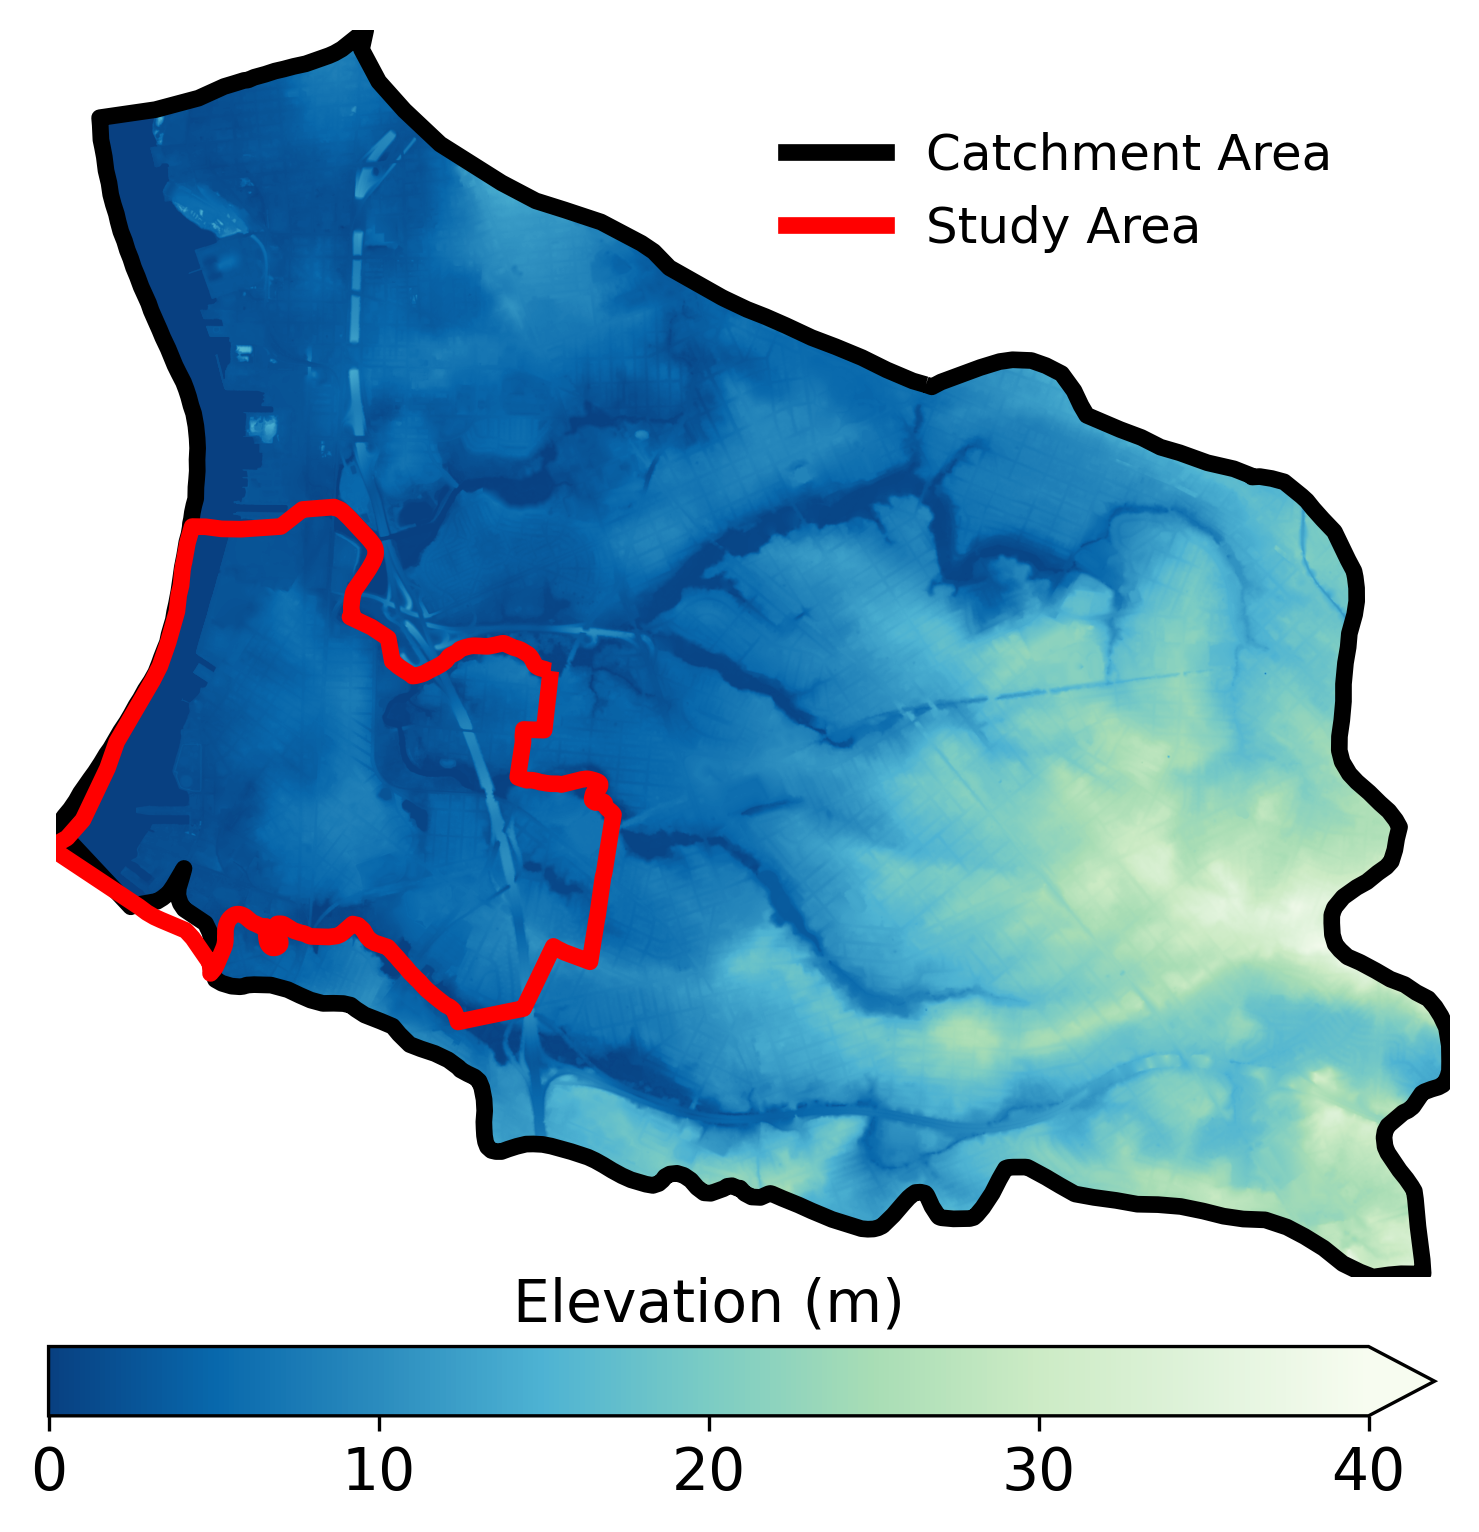

In [38]:
# Catchment area, city boundary, and dem

fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

bnd_shp.plot(color='none', edgecolor='black', lw=4, ax=ax)
clip_ref_t.plot(color='none', edgecolor='red', lw=4, ax=ax)

image_hidden = ax.imshow(dem_clip.read(1),
                         cmap='GnBu_r',
                         vmin=0,
                         vmax=40)
rasterio.plot.show(dem_clip, cmap='GnBu_r',
                   transform=dem_clip.transform,
                   ax=ax, vmin=0, vmax=40)

cbar = fig.colorbar(image_hidden, ax=ax,
                    orientation='horizontal',
                    extend='max',
                    fraction=.05,
                    pad=.05)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('Elevation (m)', size=14)

ax.axis('off')

legend_elements = [Line2D([0], [0], color='black', lw=4,
                          label='Catchment Area'),
                   Line2D([0], [0], color='red', lw=4,
                          label='Study Area')]

# Create the figure
ax.legend(handles=legend_elements, loc='center',
          fontsize='large',
          frameon=False,
          bbox_to_anchor=(.72, .87))

# Output figure
file_dir = join(FIG_DIR, 'workflow')
filename = 'dem_bounds.png'
prepare_saving(join(file_dir, filename))
fig.savefig(join(file_dir, filename),
            dpi=300,
            bbox_inches='tight')

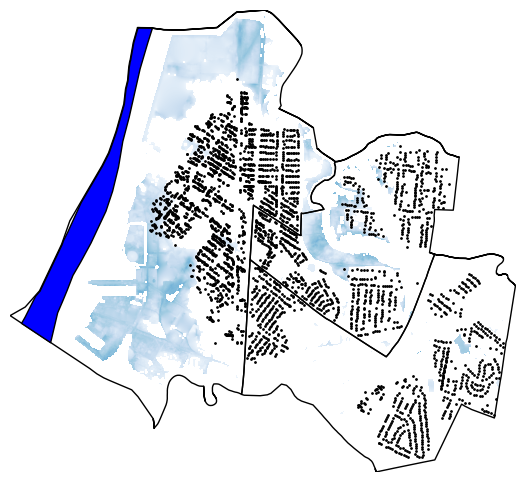

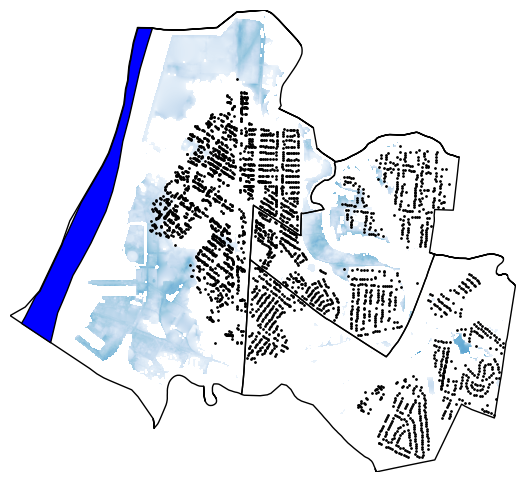

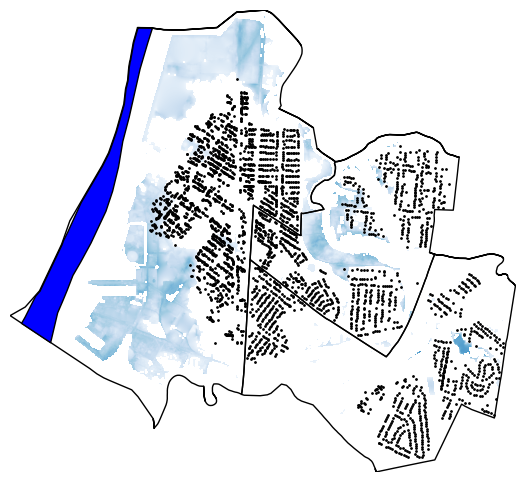

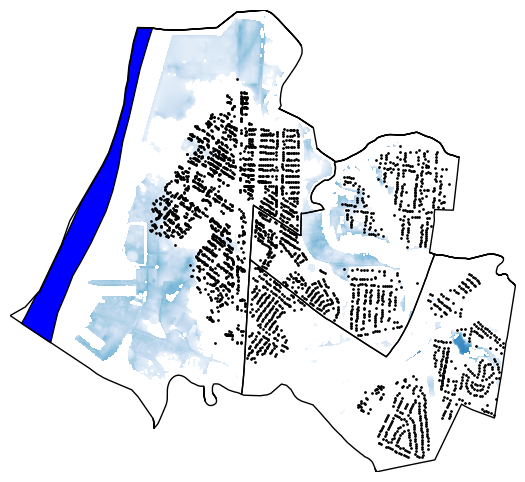

In [73]:
# Second piece - structure locations + hazard example

# Following other examples in the literature, these are pretty
# tiny figure inserts. So, don't use up space for legends
# This type of stuff is captured in the workflow text
# Let's plot the Mid depths
scen = 'Mid'

for ret_per in ['5', '50', '100', '500']:

    df_id = ret_per + '_' + scen
    depth_r = depth_dict[df_id]
    
    nsi_plot = nsi_geo.to_crs(HAZ_CRS)
    fz_plot = fz_geo.to_crs(HAZ_CRS)
    sfha_plot = fz_plot[fz_plot['fld_zone'].isin(['A', 'AE'])]
    open = fz_plot[fz_plot['fld_zone'] == 'OPEN WATER']
    t_plot = tract_geo.to_crs(HAZ_CRS)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    nsi_plot.plot(markersize=1, color='black', ax=ax)
    t_plot.plot(ax=ax, color='none', edgecolor='black', lw=1)
    open.plot(ax=ax, color='blue', edgecolor='black')
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(depth_r.read(1),
                             cmap='Blues',
                             vmin=0,
                             vmax=4)
    rasterio.plot.show(depth_r, cmap='Blues', ax=ax, vmin=0, vmax=4)
    
    ax.axis('off')
    
    # Output figure
    filename = 'workflow_nsi_depth_' + scen + '_' + ret_per + '.png'
    fig.savefig(join(FIG_DIR, filename),
                dpi=600,
                bbox_inches='tight')

/tmp/ipykernel_375427/1500243705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hazus_plot[['low', 'high']] = pd.DataFrame(hazus_plot['params'].tolist(),
/tmp/ipykernel_375427/1500243705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hazus_plot[['low', 'high']] = pd.DataFrame(hazus_plot['params'].tolist(),


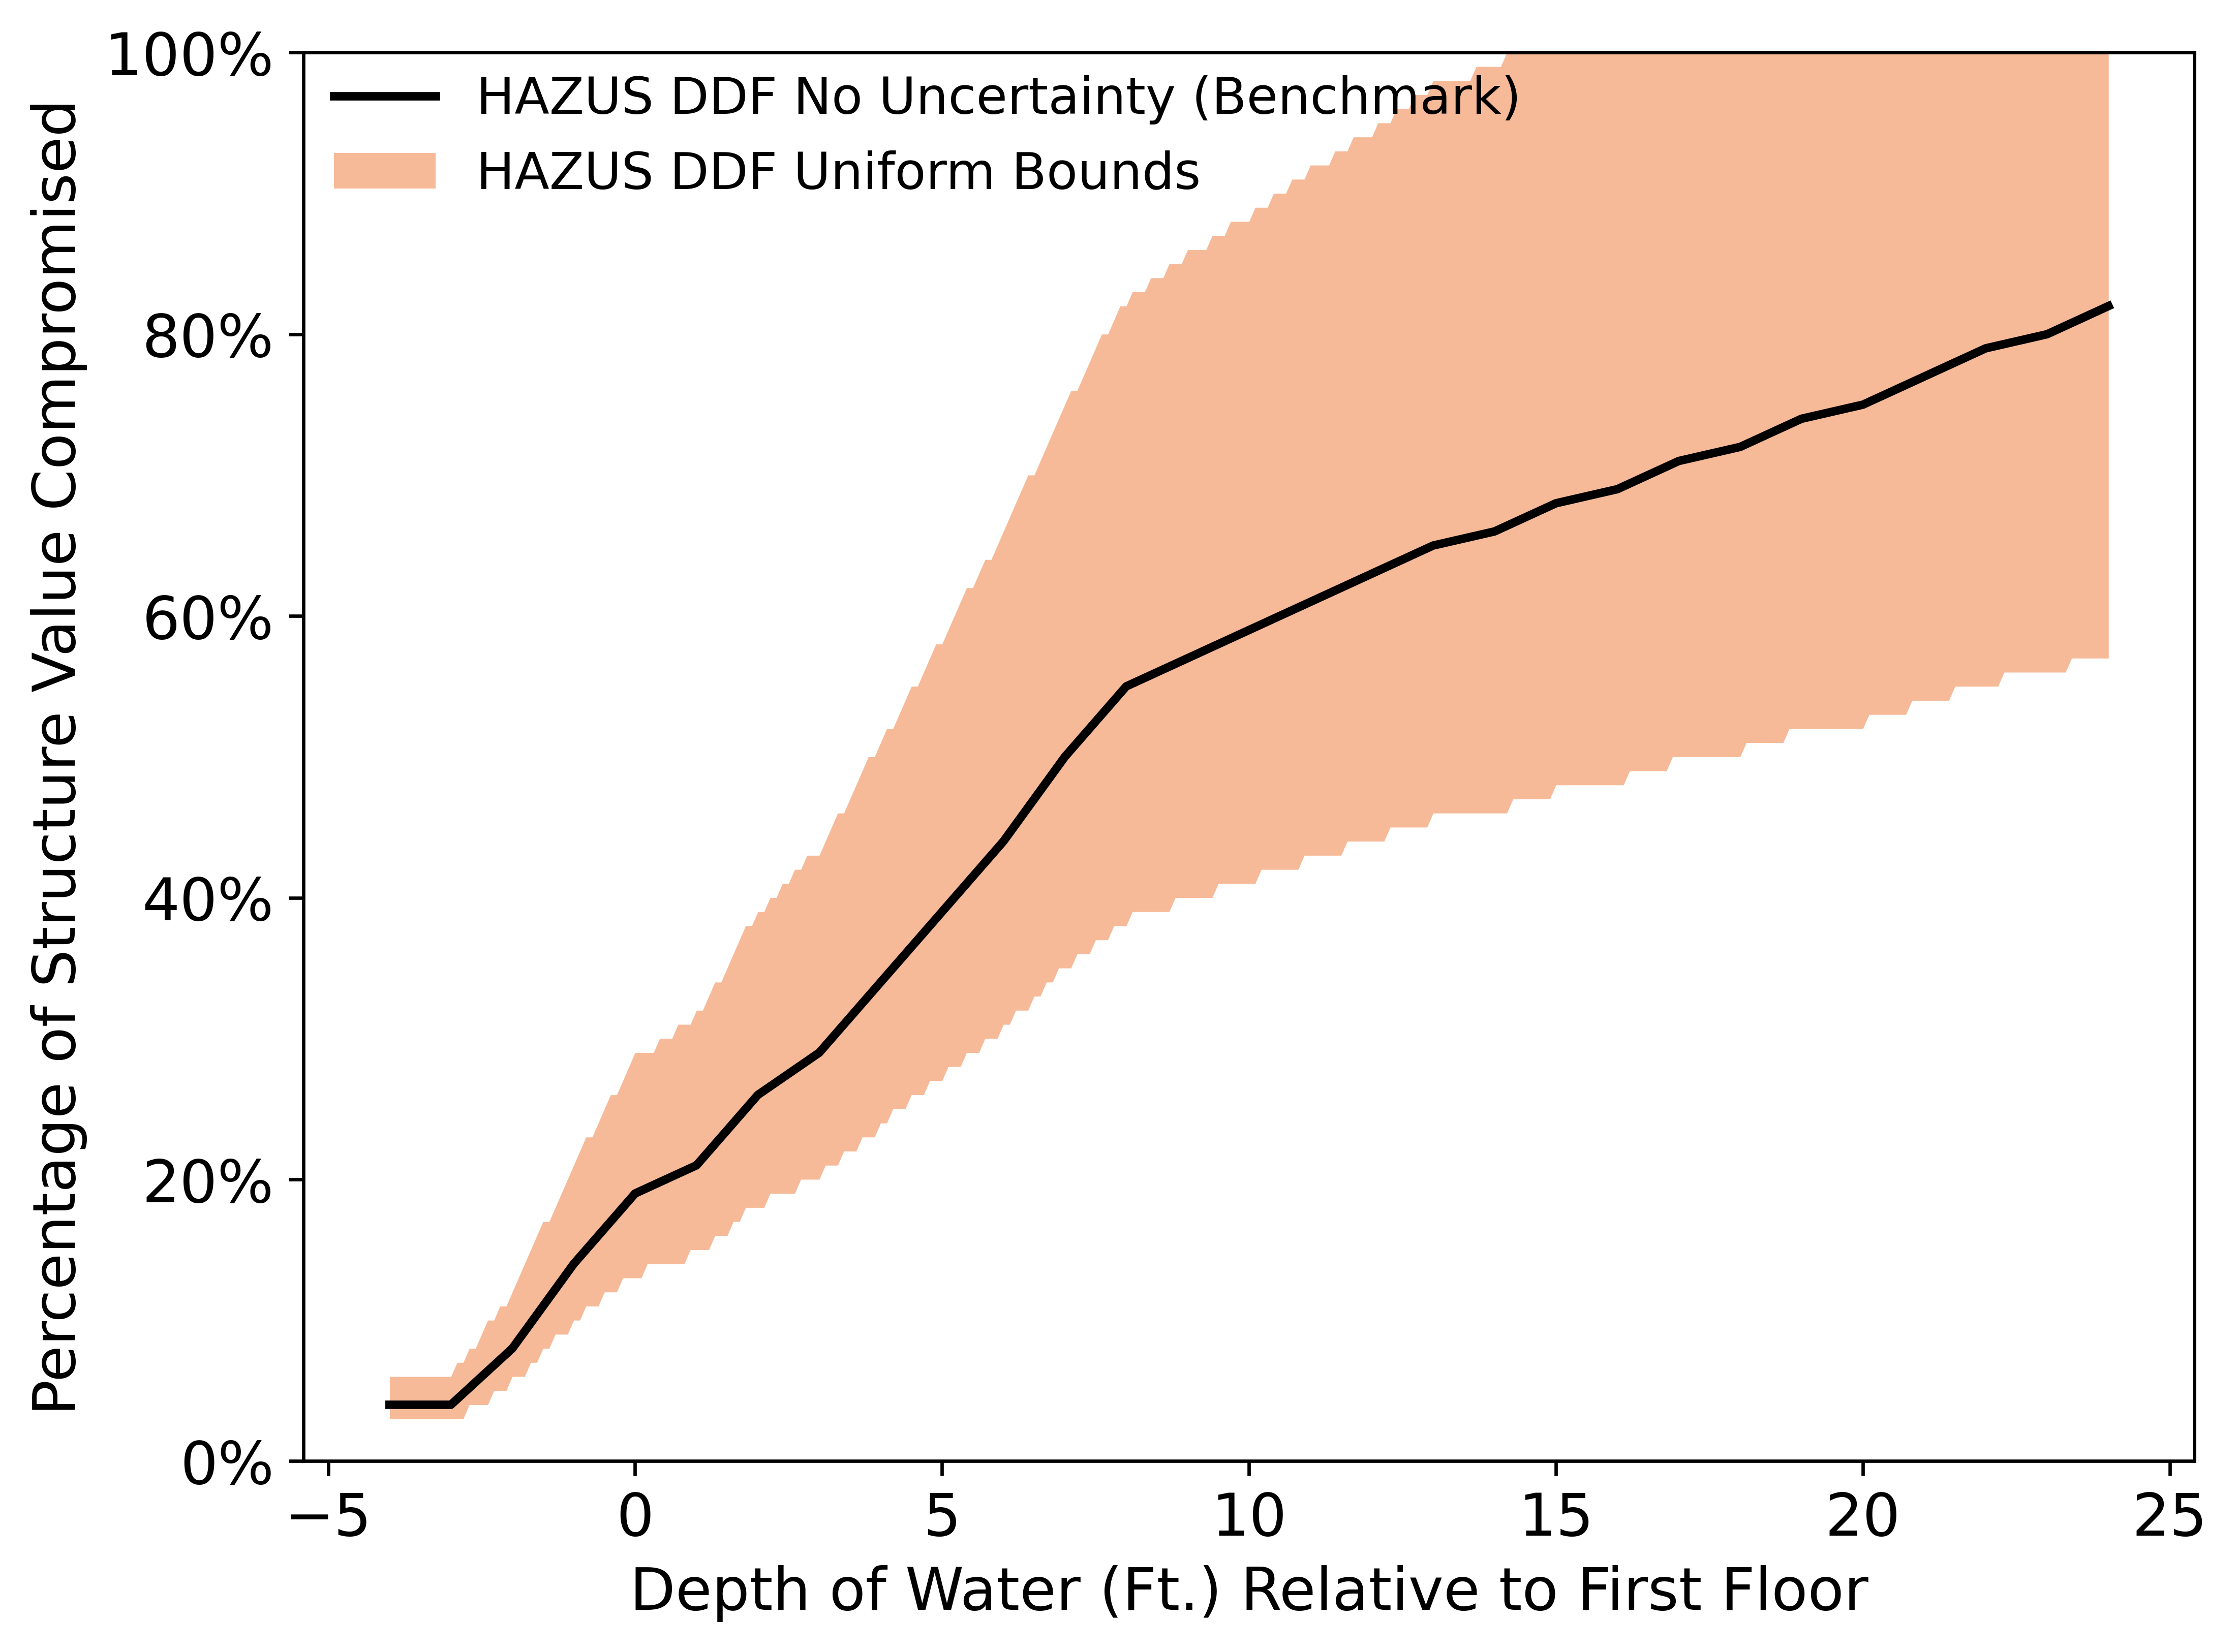

In [21]:
# Plot a few depth-damage functions
# Compare ddfs w/o uncertainty to those with uncertainty
# Let's do 1SWB, the most common occtype in our case study
# according to the no uncertainty data
hazus_id = '2SWB_A'
hazus_plot = hazus_ddfs[hazus_ddfs['ddf_id'] == hazus_id]
hazus_nounc_plot = hazus_nounc[hazus_nounc['ddf_id'] == hazus_id]

# Add low/high to hazus_plot
hazus_plot[['low', 'high']] = pd.DataFrame(hazus_plot['params'].tolist(),
                                           index=hazus_plot.index)

# Plot our ddf that is specified above
fig, ax = plt.subplots(figsize=(8, 6),
                       dpi=600)

# First, plot no uncertainty as a black line
hazus_nounc_plot.plot(x='depth_ft',
                      y='rel_dam',
                      ax=ax,
                      lw=2,
                      legend=False,
                      color='black')

# Second, plot the hazus uncertainty low/high
ax.fill_between(hazus_plot['depth_ft'],
                hazus_plot['low'],
                hazus_plot['high'],
                alpha=.5,
                lw=0,
                color='#EE7733')

# Limit axis from -9.1 to +10.1
# ax.set_xlim([-9.1, 10])
ax.set_ylim([0, 1])

# Style the axes
ax.set_xlabel('Depth of Water (Ft.) Relative to First Floor', size=14)
ax.set_ylabel('Percentage of Structure Value Compromised', size=14)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.tick_params(labelsize=14)

# Add a custom legend in the top left
legend_elements = [Line2D([0], [0], color='black', lw=2, label='HAZUS DDF No Uncertainty (Benchmark)'),
                   Patch(facecolor='#EE7733', alpha=.5,
                         label='HAZUS DDF Uniform Bounds'),
                   ]
ax.legend(handles=legend_elements,
          bbox_to_anchor=(.33, .94),
          loc='center',
          fontsize='large',
          frameon=False)

filename = 'workflow_ddf_' + hazus_id + '.png'
fig.savefig(join(FIG_DIR, filename),
            dpi=600,
            bbox_inches='tight')


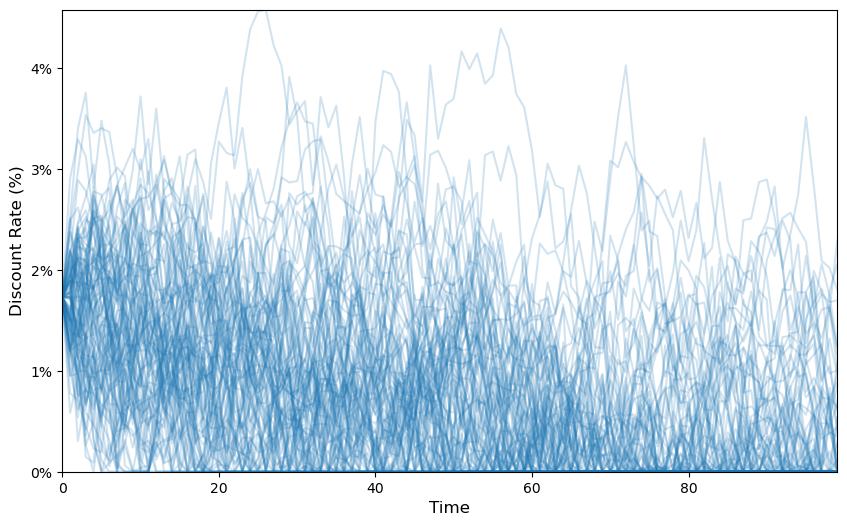

In [76]:
# Plot a few discount rate chains
x = np.arange(100)
ys = np.array(dr_chains.T)[:100]
segs = np.zeros((100, 100, 2))
segs[:, :, 1] = ys
segs[:, :, 0] = x

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ys.min(), ys.max())
from matplotlib.collections import LineCollection
line_segments = LineCollection(segs, alpha=.2,
                               linestyle='solid')
ax.add_collection(line_segments)

ax.set_ylabel('Discount Rate (%)', size=12)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
ax.set_xlabel('Time', size=12)
ax.tick_params(labelsize=10)
filename = 'workflow_dr_sample.png'
fig.savefig(join(FIG_DIR, filename),
            dpi=600,
            bbox_inches='tight')

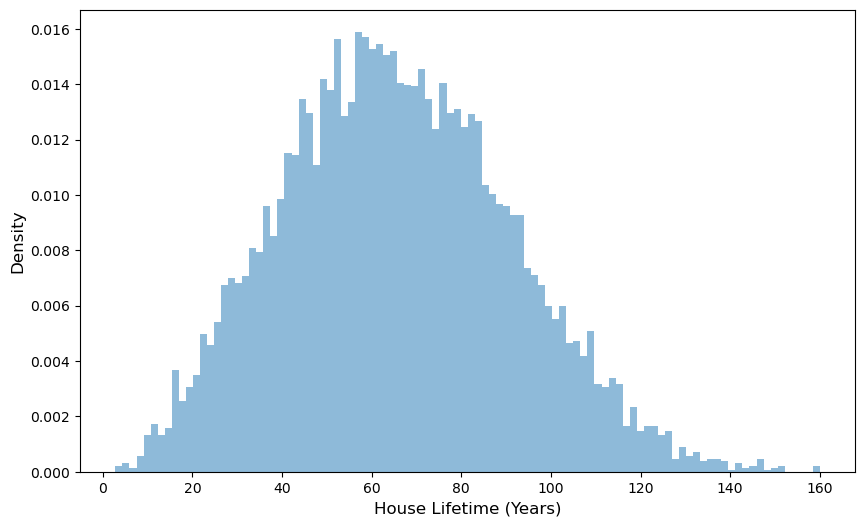

In [95]:
# Plot house lifetime distribution (not the exact ones
# that we drew from but the realizations of our draws
# are avabilble and shown elsewhere)
rng = np.random.default_rng()
lifetime = pd.Series(rng.weibull(W_SHAPE, N_SOW)*W_SCALE)

fig, ax = plt.subplots(figsize = (10, 6))
lifetime.plot(kind='hist', bins=100, density=True, alpha=.5)
# ax.set_xlim([0, 160])
ax.set_ylabel('Density', size=12)
ax.set_xlabel('House Lifetime (Years)', size=12)
ax.tick_params(labelsize=10)

filename = 'workflow_lifetime.png'
fig.savefig(join(FIG_DIR, filename),
            dpi=600,
            bbox_inches='tight')

In [13]:
# Plot elevation costs for different heights
e_c_ens['fnd_type'] = np.where(e_c_ens['fnd_type'] == 'B',
                               'Basement',
                               'Slab')

e_c_ens['bldgtype'] = np.where(e_c_ens['bldgtype'] == 'M',
                               'Masonry',
                               'Wood')

e_c_ens = e_c_ens.rename(columns={'cost_sqft_unc': 'Cost per Sq Ft. ($)',
                                  'elev_ht': 'Elevation Amount (Ft.)',
                                  'fnd_type': 'Foundation Type',
                                  'bldgtype': 'Foundation Material'})

/jumbo/keller-lab/Applications/mambaforge/envs/flrisk/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


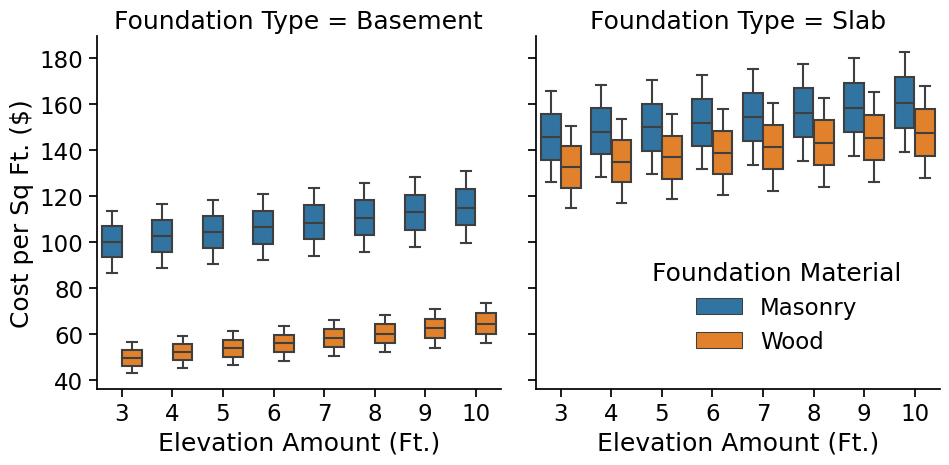

In [24]:
with sns.plotting_context(context="notebook", font_scale=1.5):
    g = sns.catplot(data=e_c_ens,
                kind='box',
                x='Elevation Amount (Ft.)',
                y='Cost per Sq Ft. ($)',
                hue='Foundation Material',
                col='Foundation Type')
    sns.move_legend(g, "center", bbox_to_anchor=(.65, .35))
filename = 'workflow_elevcost.png'
fig = g.fig
fig.savefig(join(FIG_DIR, filename),
            dpi=600,
            bbox_inches='tight')

# Fig S2 - Show NSI fixed values vs. w/ uncertainty

In [ ]:
# 